In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import musical_mdn
import mixture_rnn
import sketch_mixture

# Test Running Network

In [2]:
# Instantiate Running Network
net = mixture_rnn.MixtureRNN(mode = mixture_rnn.NET_MODE_RUN, n_hidden_units = 128, n_mixtures = 10, batch_size = 1, sequence_length = 1)

INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: mixture-rnn-3layers-128units vars: 348816


Test Input: [ 0.01100834  8.94228724]
INFO:tensorflow:Restoring parameters from /Users/charles/src/mdn-experiments/mixture-rnn-3layers-128units
Test Output:


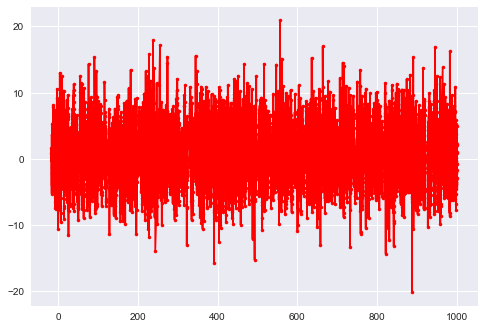

                  t             x          time
count  10001.000000  10001.000000  10001.000000
mean       0.100014      0.610792    479.500826
std        0.506247      3.921042    294.430238
min       -7.830667    -20.133340    -16.763368
25%        0.068183     -1.990909    226.321966
50%        0.098980      0.318212    466.564703
75%        0.129653      3.166123    725.400532
max        6.239654     20.903446   1001.325268
Window: 1000 to 1100


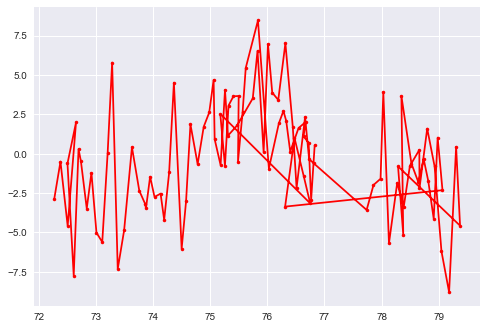

Window: 2000 to 2100


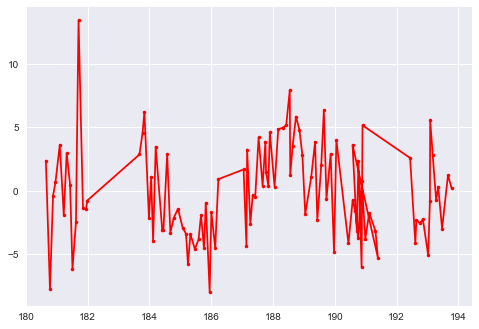

Window: 3000 to 3100


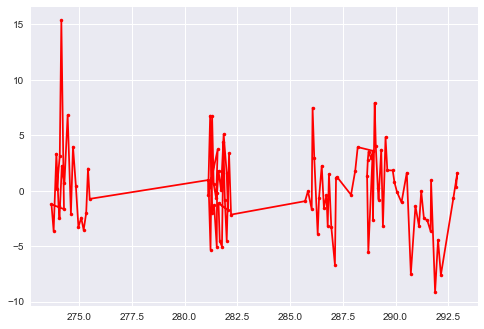

Window: 4000 to 4100


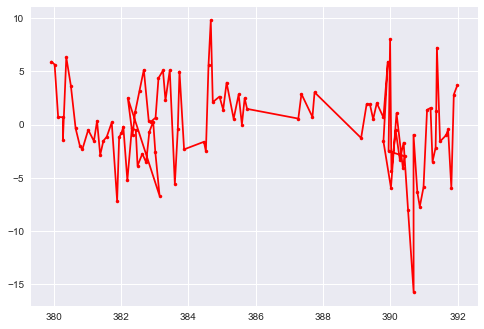

Window: 5000 to 5100


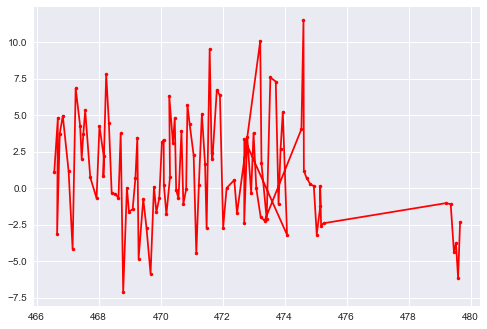

Window: 6000 to 6100


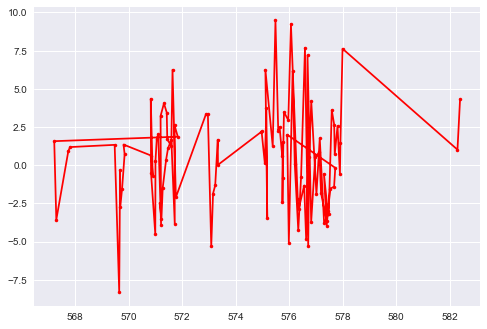

In [59]:
first_touch = np.array([(0.01 + (np.random.rand()-0.5)*0.005), (np.random.rand()-0.5)*20])
print("Test Input:",first_touch)
with tf.Session() as sess:
    perf = net.generate_performance(first_touch,10000,sess)
print("Test Output:")
perf_df = pd.DataFrame({'t':perf.T[0], 'x':perf.T[1]})
perf_df['time'] = perf_df.t.cumsum()
#plt.show(perf_df.plot('time','x',kind='scatter'))
plt.plot(perf_df.time, perf_df.x, '.r-')
plt.show()
print(perf_df.describe())
## Investigate Output
window = 100
for n in [1000,2000,3000,4000,5000,6000]:
    print("Window:", str(n),'to',str(n+window))
    plt.plot(perf_df[n:n+window].time, perf_df[n:n+window].x, '.r-')
    plt.show()

# input_touch = first_touch.reshape([1,1,net.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
# if net.state is not None:
#     feed = {net.x: input_touch, net.init_state: net.state}
# else:
#     feed = {net.x: input_touch}
# pis, locs_1, locs_2, scales_1, scales_2, corr, net.state = sess.run([net.pis, net.locs_1, net.locs_2, net.scales_1, net.scales_2,  net.corr, net.final_state], feed_dict=feed)
# #x_1, x_2 = sketch_mixture.sample_mixture_model(pis, locs_1, locs_2, scales_1, scales_2, corr, temp=1.0, greedy=False)


[0.00805137454588791, -9.408807474576161]

In [25]:
x_t_log = musical_mdn.generate_data()

Generating 50000 toy data samples.
                  t             x
count  50000.000000  50000.000000
mean       0.099998      0.006379
std        0.007040      5.048061
min        0.000100    -11.109844
25%        0.095246     -4.831742
50%        0.100000      0.020131
75%        0.104664      4.838098
max        0.127788     11.416225


## Test Training

In [ ]:
net = MixtureRNN()
x_t_log = musical_mdn.generate_data()
loader = musical_mdn.SequenceDataLoader(num_steps = 121,batch_size = 100, corpus = x_t_log)
losses = net.train(loader, 1, saving=True)
## Plot the losses.
plt.plot(losses)
plt.show()